In [13]:
! pip install onnxruntime
! pip install matplotlib

In [14]:
import onnxruntime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
! ls /gsn/models_archive

model_2023-12-14_23:28:17.onnx


In [16]:
model_path = '/gsn/models_archive/model_2023-12-14_23:28:17.onnx'
image_path = "/gsn/datasets/test/Set14/image_SRF_4/img_001_SRF_4_HR.png"
in_image_path = "/gsn/demo/in.jpg"
out_image_path = "/gsn/demo/out.jpg"
image_size = 100

In [17]:
# Load the image
img = Image.open(image_path)
img.save(in_image_path)

In [18]:
def preprocess_image(img, image_size):

    # Resize the image
    img = img.resize((image_size, image_size))

    # Convert the image to YCbCr color space
    img_ycbcr = img.convert('YCbCr')
    y, cb, cr = img_ycbcr.split()

    # Convert Y channel to NumPy array
    img_ndarray = np.asarray(y)

    # Add batch and channel dimensions
    img_4 = np.expand_dims(np.expand_dims(img_ndarray, axis=0), axis=0)

    # Normalize the image
    imginput = img_4.astype(np.float32) / 255.0
    
    return imginput, cb, cr

In [19]:
input_img, cb, cr = preprocess_image(img, image_size)

In [20]:
ort_session = onnxruntime.InferenceSession(model_path)
input_name = ort_session.get_inputs()[0].name
inputs = {input_name: input_img}
out_img = ort_session.run(None, inputs)
out_img = np.array(out_img)
out_img = out_img.squeeze(0)
out_img = out_img.squeeze(0)
out_img *= 255.0
out_img = out_img.clip(0, 255)
out_img = Image.fromarray(np.uint8(out_img[0]), mode='L')
out_img_cb = cb.resize(out_img.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img.size, Image.BICUBIC)
out_img = Image.merge(
    "YCbCr", [out_img,out_img_cb,out_img_cr,]).convert("RGB")

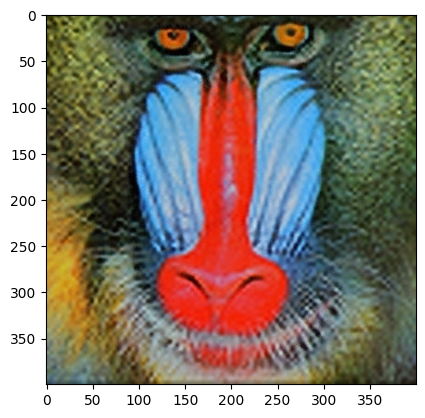

In [21]:
plt.imshow(out_img)
out_img.save(out_image_path)